# Предсказание согласования заявки

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge,Lasso,LinearRegression,LogisticRegression,LassoCV
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import scale,StandardScaler,PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Читаем данные
data = pd.read_csv('../data/grants.csv')
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

In [3]:
#Обработка пропущенных значений
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

X_cat=X[categorical_cols].fillna('NA', axis=0).applymap(str)
X_real_mean=X[numeric_cols].fillna(calculate_means(X[numeric_cols]))

In [4]:
#Обработка категориальных признаков
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

In [5]:
#Разделение выборки
(X_train_real_mean, X_test_real_mean,y_train, y_test) = train_test_split(X_real_mean,y, test_size=0.3, 
                                                                         random_state=0,stratify=y)
(X_train_cat_oh,X_test_cat_oh) = train_test_split(X_cat_oh, test_size=0.3, random_state=0,stratify=y)

In [6]:
#Масштабирование
scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_mean)
X_test_real_scaled = scaler.transform(X_test_real_mean)

In [7]:
#Обучение модели
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

X_train_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

estimator = LogisticRegression(class_weight='balanced')
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_scaled, y_train)
predicted = optimizer.predict_proba(X_test_scaled)[:,1]
roc = roc_auc_score(y_test, predicted)
roc

0.876918110847402

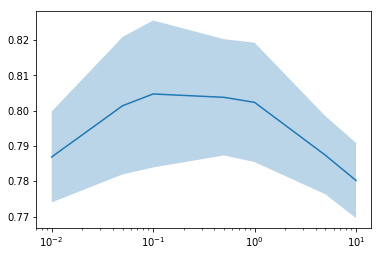

In [8]:
#Оценка точности
def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
plot_scores(optimizer)

In [9]:
#Добавление полином. признаков степени 2
transform = PolynomialFeatures(2)
X_train_real_poly = transform.fit_transform(X_train_real_mean)
X_test_real_poly = transform.transform(X_test_real_mean)
scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_poly)
X_test_real_scaled = scaler.transform(X_test_real_poly)

X_train_poly = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_poly = np.hstack((X_test_real_scaled, X_test_cat_oh))

optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(X_train_poly, y_train)
Z = optimizer.predict_proba(X_test_poly)[:,1]
roc = roc_auc_score(y_test, Z)
roc

0.8856652933888616

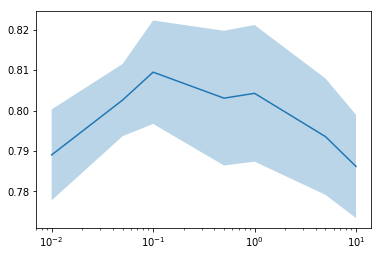

In [10]:
#Оценка точности
plot_scores(optimizer)